<a href="https://www.kaggle.com/code/thirumani/predicting-bigg-boss-hindi-ott-season-2-winner?scriptVersionId=134077121" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Predicting Hindi Bigg Boss (बिग बॉस हिंदी) OTT 2 Season Winner

## Dataset https://www.kaggle.com/datasets/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

In [1]:
from IPython.display import IFrame
import datetime
print("Notebook was last executed on:", datetime.date.today().strftime("%Y-%b-%d"))

Notebook was last executed on: 2023-Jun-19


In [2]:
# Source: Wikipedia
IFrame('https://upload.wikimedia.org/wikipedia/en/3/35/Bigg_Boss_Ott_2_Logo.jpg', width=430, height=260)

### Importing Required Python Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
from babel.numbers import format_currency
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

### Check and import dataset

In [4]:
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

-rw-r--r-- 1 nobody nogroup 192213 Jun 19 05:29 /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

There are 971 rows and 35 columns in the dataset


## 🌟 Exploratory Data Analysis (EDA)

In [5]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,NaN,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,NaN,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,NaN,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,Hindi,1,Bobby Darling,Activist,Transgender,03-Nov-06,NaN,1.0,NaN,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,NaN,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [6]:
bigg_boss.tail(10).T

,961,962,963,964,965,966,967,968,969,970
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,5,5,5,5,5,5,5,5,5,5
Name,Rinosh George,Sagar Surya,Shiju Abdul Rasheed,Sobha Viswanath,Sreedevi Menon,Sruthi Lakshmi,Vishnu Joshi,Hanan Hameed,Omar Lulu,Anu Joseph
Profession,Singer,Actor,Actor,Entrepreneur,Social Media Star,Soap Actress,Fitness Trainer,Social Media Star,Film Director,Soap Actress
Gender,Male,Male,Male,Female,Female,Female,Male,Female,Male,Female
Entry Date,26-Mar-23,26-Mar-23,26-Mar-23,26-Mar-23,26-Mar-23,26-Mar-23,26-Mar-23,NaN,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,NaN,9.0,NaN,NaN,5.0,8.0,12.0,3.0,6.0,10.0
Entry Numbr,2.0,5.0,16.0,4.0,8.0,17.0,6.0,19.0,20.0,21.0
Wild Card,No,No,No,No,No,No,No,Yes,Yes,Yes


In [7]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner
824,Marathi,4,Amruta Dhongade,Soap Actress,Female,02-Oct-22,NaN,14.0,NaN,No,98,19,02-Oct-22,08-Jan-23,Mahesh Manjrekar,NaN,0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,8.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,7.0,1.0,0.0
727,Tamil,5,Raju Jeyamohan,Actor,Male,03-Oct-21,NaN,NaN,NaN,No,105,20,03-Oct-21,16-Jan-22,Kamal Haasan,Ramya Krishnan,"38,00,000",Star Vijay,Disney+ Hotstar,18.60,Tamil Nadu,Chennai,No,8.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,10.0,1.0,1.0
419,Kannada,5,Samyuktha Hegde,Actress,Female,NaN,NaN,NaN,NaN,Yes,106,20,15-Oct-17,28-Jan-18,Sudeep,NaN,0,Colors Super,Voot,NaN,Karnataka,Bengaluru,No,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
940,Malayalam,4,Naveen Arakkal,Soap Actor,Male,27-Mar-22,NaN,5.0,NaN,No,98,20,27-Mar-22,03-Jul-22,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,4.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
594,Telugu,5,Ravi,TV Anchor,Male,05-Sep-21,28-Nov-21,12.0,NaN,No,105,19,05-Sep-21,19-Dec-21,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,18.20,"Telangana, Andhra Pradesh",Hyderabad,No,9.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,7.0,0.0,0.0
890,Malayalam,2,Alasandra Johnson,Model,Female,05-Jan-20,NaN,NaN,NaN,No,75,22,05-Jan-20,20-Mar-20,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,11.03,Kerala,Chennai,No,4.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
354,Kannada,2,Harshika Poonacha,Actress,Female,29-Jun-14,NaN,7.0,NaN,No,98,15,29-Jun-14,5-Oct-14,Sudeep,NaN,0,Asianet Suvarna,NaN,NaN,Karnataka,Lonavala,No,2.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
587,Telugu,5,Kajal,Radio Jockey,Female,05-Sep-21,12-Dec-21,14.0,NaN,No,105,19,05-Sep-21,19-Dec-21,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,18.20,"Telangana, Andhra Pradesh",Hyderabad,No,10.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,7.0,0.0,0.0
660,Tamil,1,Kaajal Pasupathi,Actress,Female,NaN,NaN,10.0,NaN,Yes,98,19,25-Jun-17,30-Sep-17,Kamal Haasan,NaN,0,Star Vijay,NaN,7.80,Tamil Nadu,Chennai,No,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
671,Tamil,2,Riythvika,Actress,Female,17-Jun-18,NaN,NaN,NaN,No,105,17,17-Jun-18,30-Sep-18,Kamal Haasan,NaN,"50,00,000",Star Vijay,Disney+ Hotstar,8.20,Tamil Nadu,Chennai,No,6.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,8.0,1.0,1.0


In [8]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Language                            971 non-null    object 
 1   Season Number                       971 non-null    object 
 2   Name                                971 non-null    object 
 3   Profession                          971 non-null    object 
 4   Gender                              971 non-null    object 
 5   Entry Date                          842 non-null    object 
 6   Elimination Date                    187 non-null    object 
 7   Elimination Week Number             824 non-null    float64
 8   Entry Numbr                         34 non-null     float64
 9   Wild Card                           971 non-null    object 
 10  Season Length                       971 non-null    int64  
 11  Number of Housemates                971 non-n

In [9]:
bigg_boss.describe().T.round(2).style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
Elimination Week Number,824.000000,9.050000,4.850000,1.000000,5.000000,9.000000,14.000000,20.000000
Entry Numbr,34.000000,9.470000,5.720000,1.000000,5.000000,9.000000,13.000000,21.000000
Season Length,971.000000,99.290000,19.700000,28.000000,98.000000,100.000000,105.000000,142.000000
Number of Housemates,971.000000,18.330000,2.400000,10.000000,17.000000,18.000000,20.000000,24.000000
Average TRP,550.000000,9.060000,5.740000,2.720000,3.810000,7.800000,15.000000,20.100000
Number of Evictions Faced,961.000000,4.350000,3.010000,0.000000,2.000000,4.000000,6.000000,14.000000
Number of times elected as Captain,927.000000,0.580000,0.780000,0.000000,0.000000,0.000000,1.000000,5.000000
Number of re-entries,958.000000,0.100000,0.320000,0.000000,0.000000,0.000000,0.000000,3.000000
Walked,958.000000,0.080000,0.280000,0.000000,0.000000,0.000000,0.000000,2.000000
Ejected,959.000000,0.040000,0.190000,0.000000,0.000000,0.000000,0.000000,1.000000


In [10]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [11]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            971 non-null    object        
 1   Season Number                       971 non-null    object        
 2   Name                                971 non-null    object        
 3   Profession                          971 non-null    object        
 4   Gender                              971 non-null    object        
 5   Entry Date                          842 non-null    datetime64[ns]
 6   Elimination Date                    187 non-null    datetime64[ns]
 7   Elimination Week Number             824 non-null    Int32         
 8   Entry Numbr                         34 non-null     float64       
 9   Wild Card                           971 non-null    object        
 10  Season Length             

In [12]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col, "-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 22
Number of unique values in Name - 910
Number of unique values in Profession - 80
Number of unique values in Gender - 4
Number of unique values in Entry Date - 63
Number of unique values in Elimination Date - 114
Number of unique values in Elimination Week Number - 20
Number of unique values in Entry Numbr - 21
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 20
Number of unique values in Number of Housemates - 11
Number of unique values in Season Start Date - 54
Number of unique values in Season End Date - 51
Number of unique values in Host Name - 15
Number of unique values in Guest Host Name - 7
Number of unique values in Prize Money (INR) - 18
Number of unique values in Broadcasted By - 12
Number of unique values in OTT Platform - 3
Number of unique values in Average TRP - 29
Number of unique values in Most Viewed States - 7
Number of unique values in House Locatio

In [13]:
# Number of seasons in all Indian languages
print("Total", bigg_boss.groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted (in TV & OTT)")
print(bigg_boss['Winner'].sum().astype(int) + 2, "seasons completed")
print(bigg_boss.loc[bigg_boss['Winner'].isnull(), :].groupby('Language')['Season Number'].nunique().sum(), "season(s) running")

# For Bigg Boss Hindi season 8 & Malayalam season 2 winner was not declared

Total 54 seasons broadcasted (in TV & OTT)
52 seasons completed
2 season(s) running


In [14]:
# Seasons broadcasted ONLY in OTT platforms, eventually in Television
print(bigg_boss.loc[bigg_boss['OTT Season']=='Yes'].groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted ONLY in OTT platforms")

5 seasons broadcasted ONLY in OTT platforms


## 📊 Bigg Boss Hindi has many seasons compared to other Indian languages. So, the number of housemates are more in Hindi.

In [15]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        19
Kannada      10
Tamil         7
Telugu        7
Malayalam     5
Marathi       4
Bengali       2
Name: Season Number, dtype: int64


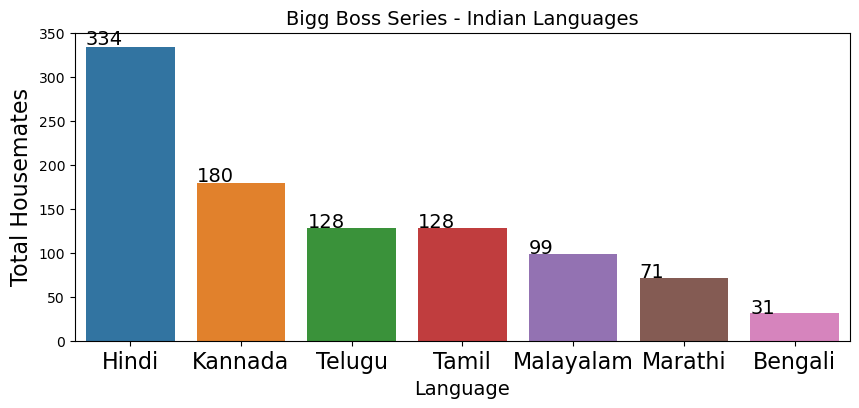

In [16]:
# Total number of Bigg Boss housemates, language wise
fig = plt.figure(figsize=(10, 4))
ax = sns.countplot(x='Language', data=bigg_boss, order=bigg_boss['Language'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Languages', fontsize=14)
plt.xticks(fontsize=16)
plt.xlabel("Language", fontsize=14)
plt.ylabel("Total Housemates", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

## 🇮🇳 In Bigg Boss India seasons, most of the housemates entered in first day/week

No     831
Yes    140
Name: Wild Card, dtype: int64 

No     86%
Yes    14%
Name: Wild Card, dtype: object 



<Axes: ylabel='Wild Card'>

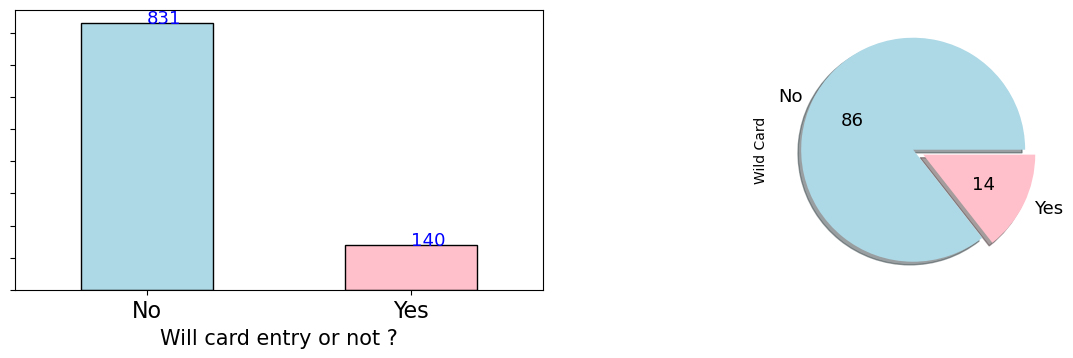

In [17]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'), "\n")

plt.figure(figsize=(15, 8))
ax1=plt.subplot(221)
bigg_boss['Wild Card'].value_counts().plot(kind='bar', color=["lightblue","pink"], ec="k")
plt.xlabel("Will card entry or not ?", fontsize=15)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss['Wild Card'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="blue")
    
ax2=plt.subplot(222)
bigg_boss['Wild Card'].value_counts().plot(kind='pie', autopct='%.0f', explode=(0,0.10), colors=["lightblue","pink"], shadow=True, fontsize=13)

In [18]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession'] = 'Commoner'

## 💚 Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions

Actress                  192
Actor                    131
Soap Actress             102
Model                     68
Singer                    58
Soap Actor                55
Commoner                  41
Social Media Star         39
Comedian                  33
TV Anchor                 28
Reality Show Alumni       27
Radio Jockey              21
Choreographer             19
Activist                  17
News Presenter            17
Pageant Winner            13
Sports Person             11
Film Director             10
Video Jockey               8
International Star         6
Politician                 6
Dancer                     6
Entrepreneur               5
Swamiji                    4
Controversial Fame         4
Producer                   3
Journalist                 3
Musician                   3
Numerologist               3
Wrestler                   3
Film director              2
Folk Artist                2
Lyricist                   2
Art Director               2
Theatre Artist

Text(0, 0.5, 'Count')

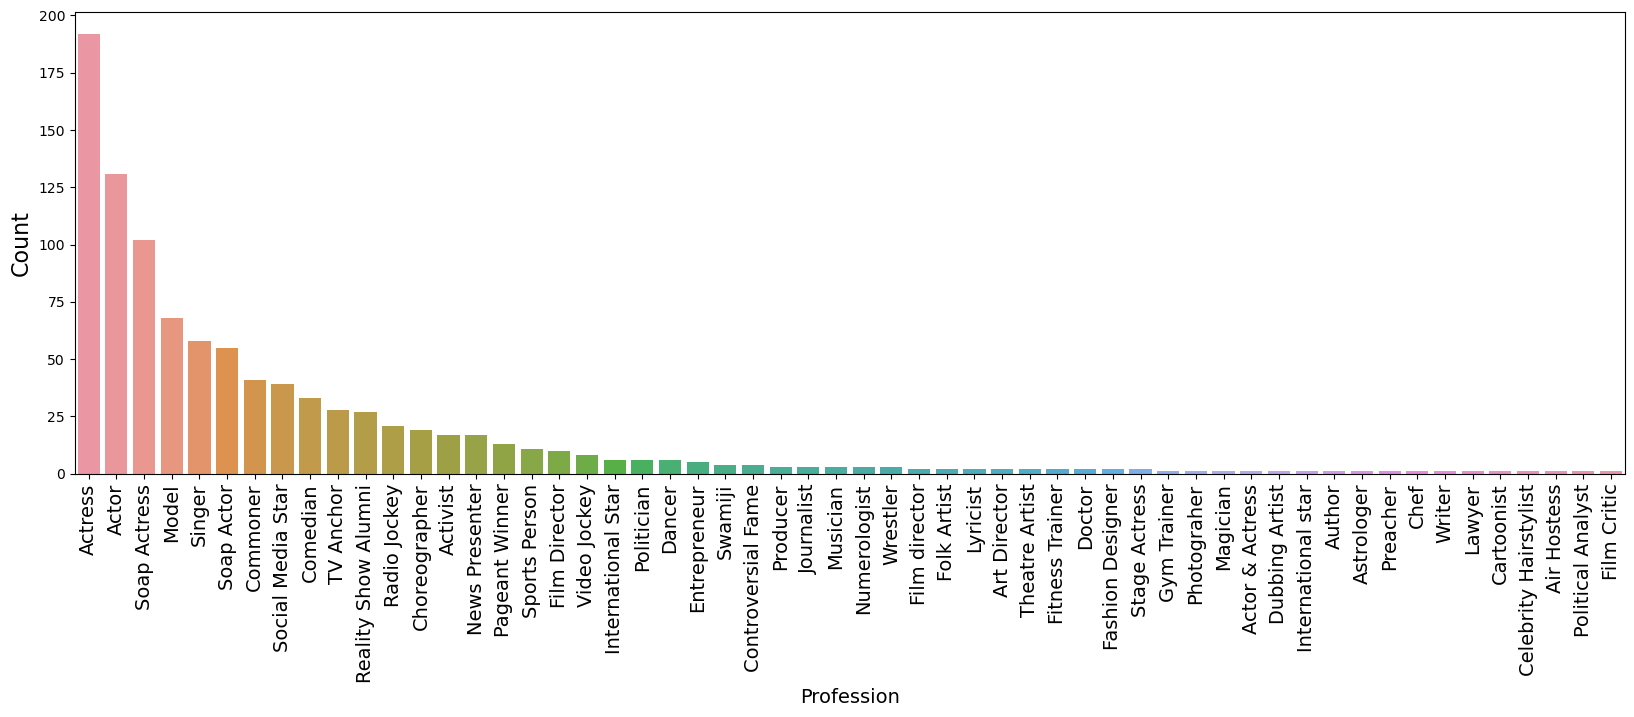

In [19]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20, 6))
sns.countplot(x='Profession', data=bigg_boss, order=bigg_boss['Profession'].value_counts().index)
plt.xticks(fontsize=14, rotation=90)
plt.xlabel("Profession", fontsize=14)
plt.ylabel("Count", fontsize=16)

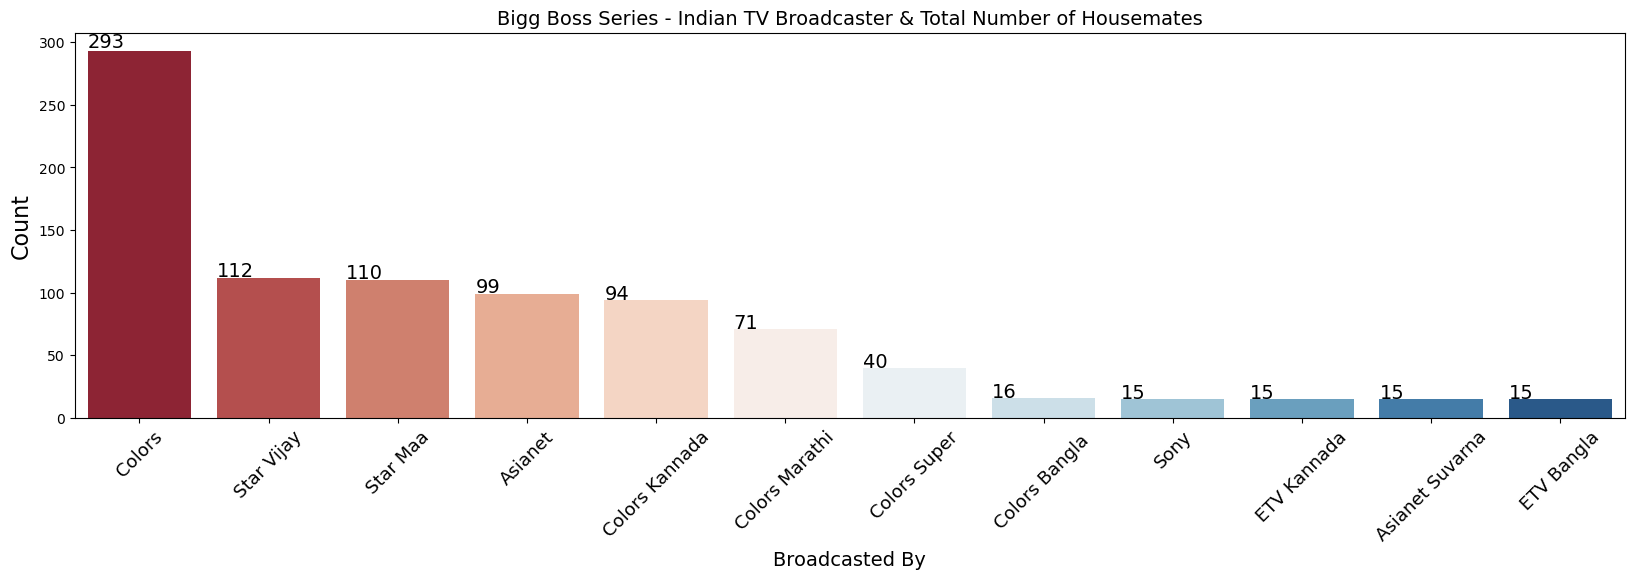

In [20]:
# TV Broadcaster
fig = plt.figure(figsize=(20, 5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu', order=bigg_boss['Broadcasted By'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian TV Broadcaster & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=13, rotation=45)
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("Count", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

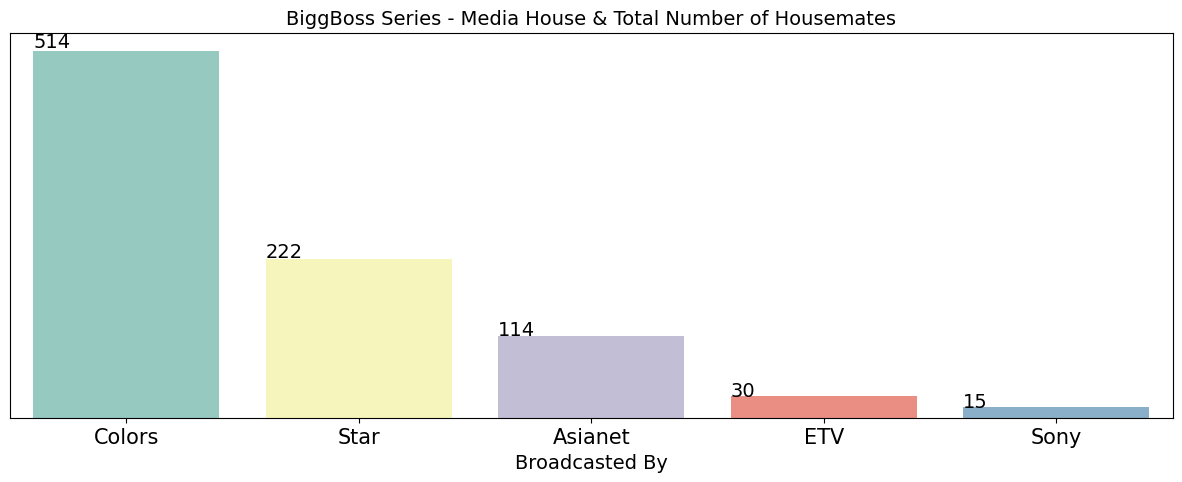

In [21]:
# Media House
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(x=bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star'), data=bigg_boss, palette='Set3', order=bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star').value_counts().index)
ax.set_title('BiggBoss Series - Media House & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

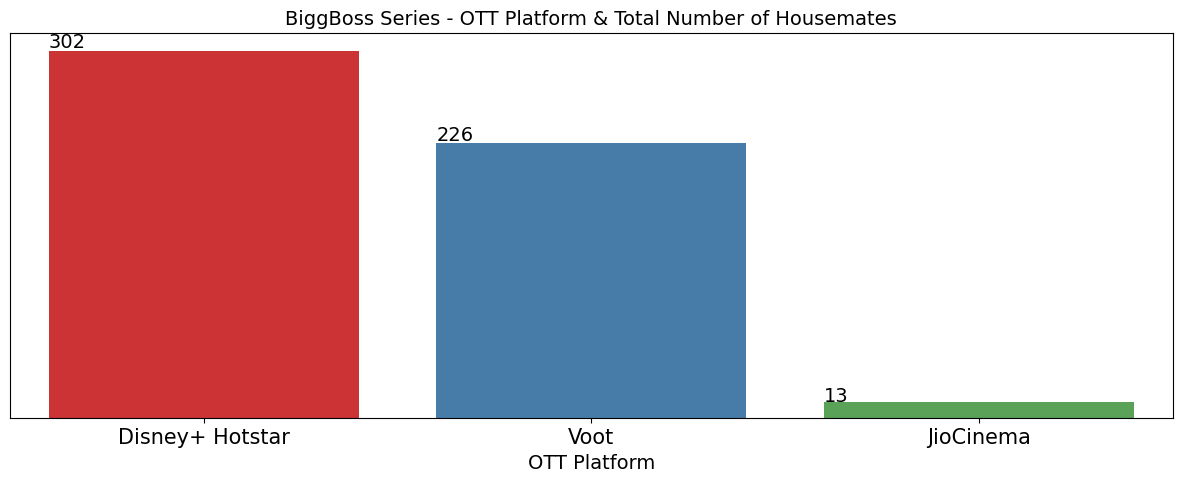

In [22]:
# OTT platforms
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(x=bigg_boss['OTT Platform'], data=bigg_boss, palette='Set1', order=bigg_boss['OTT Platform'].value_counts().index)
ax.set_title('BiggBoss Series - OTT Platform & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel("OTT Platform", fontsize=14)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

## 💢 Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [23]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan            14
Sudeep                 10
Kamal Haasan            7
Mohanlal                5
Nagarjuna               5
Mahesh Manjrekar        4
Amitabh Bachchan        1
Arshad Warsi            1
Farah Khan              1
Jeet                    1
Jr. NTR                 1
Karan Johar             1
Mithun Chakraborthy     1
Nani                    1
Shilpa Shetty           1
Name: Season Number, dtype: int64

In [24]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

Guest Host Name
Ramya Krishnan       2
Farah Khan           1
Karan Johar          1
Samantha             1
Sanjay Dutt          1
Siddhartha Jadhav    1
Simbu                1
Name: Season Number, dtype: int64

## 👩 In all Bigg Boss competitions, in languages and in all seasons, Female contestants are more

Female         506
Male           455
Transgender      8
Pair             2
Name: Gender, dtype: int64 

Female         52%
Male           47%
Transgender     1%
Pair            0%
Name: Gender, dtype: object


Text(0, 0.5, 'Count')

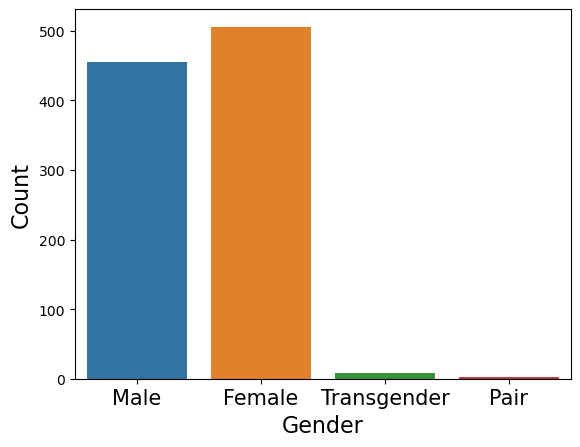

In [25]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

sns.countplot(data = bigg_boss, x = 'Gender')
plt.xticks(fontsize=15)
plt.xlabel("Gender", fontsize=16)
plt.ylabel("Count", fontsize=16)

### 7 Transgenders (LGBT) participated in all Indian languages

In [26]:
# Maximum TRP of Bigg Boss India seasons (Big Brother in India)
print("Maximum TRP", bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 20.1 

Language Season Number
  Telugu             4


In [27]:
# Smallest season of Indian Bigg Boss seasons
print("Smallest season", bigg_boss['Season Length'].min(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].min()][["Language","Season Number"]].head(1).to_string(index=False))

Smallest season 28 days 

Language Season Number
   Hindi     Halla Bol


In [28]:
# Longest season of Bigg Boss Indian seasons
print("Longest season", bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 142 days 

Language Season Number
   Hindi            14


## 🎆 Shark Tank India data set https://www.kaggle.com/datasets/thirumani/shark-tank-india

In [29]:
print("Maximum number of contestants in one season:", bigg_boss['Number of Housemates'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Housemates']==bigg_boss['Number of Housemates'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum number of contestants in one season: 24 

Language Season Number
   Hindi            15


In [30]:
print("Maximum number of evictions faced in one season:", bigg_boss['Number of Evictions Faced'].max(), "\n")
print("\nTop 4 contestants who faced highest/maximum number of evictions\n")
print(bigg_boss.loc[bigg_boss['Number of Evictions Faced']>=bigg_boss['Number of Evictions Faced'].max()-1][["Language","Season Number","Name","Number of Evictions Faced"]].head(10).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

Maximum number of evictions faced in one season: 14 


Top 4 contestants who faced highest/maximum number of evictions

Language Season Number               Name  Number of Evictions Faced
   Hindi            14      Rubina Dilaik                         14
 Kannada             8 Prashanth Sambargi                         14
   Hindi            13         Arti Singh                         13
 Kannada             7      Chandan Achar                         13
   Tamil             6     Mohammed Azeem                         13


In [31]:
bigg_boss['Season Length in weeks'] = round(bigg_boss['Season Length']/7,0).astype(pd.Int32Dtype())
bigg_boss['Evictions Faced Percentage'] = round(bigg_boss['Number of Evictions Faced']/bigg_boss['Season Length in weeks']*100,0).astype(pd.Int32Dtype())
print("Maximum percentage of evictions faced in one season:", bigg_boss['Evictions Faced Percentage'].max(), "%\n")
print("\nTop 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
print(bigg_boss.loc[bigg_boss['Evictions Faced Percentage']>=bigg_boss['Evictions Faced Percentage'].max()-10][["Language","Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(8).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

Maximum percentage of evictions faced in one season: 100 %


Top 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Language Season Number               Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
   Hindi     Halla Bol      Dimpy Ganguly                          4                       4                         100
   Hindi     Halla Bol     Sambhavna Seth                          4                       4                         100
 Kannada           OTT Jayashree Aradhaya                          6                       6                         100
   Tamil      Ultimate      Maria Juliana                         10                      10                         100
  Telugu      Non-Stop     Mitraaw Sharma                         11                      12                          92


In [32]:
print("Maximum number of re-entries:", bigg_boss['Number of re-entries'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of re-entries']>=bigg_boss['Number of re-entries'].max()-1][["Language","Season Number","Name","Number of re-entries"]].head(5).sort_values("Number of re-entries",ascending=False).to_string(index=False))

Maximum number of re-entries: 3 

Language Season Number             Name  Number of re-entries
   Hindi            16       Tina Datta                     3
   Hindi             2 Raja Chaudhary                       2
   Hindi            10   Priyanka Jagga                     2
   Hindi            14      Vikas Gupta                     2
  Telugu             1     Mumaith Khan                     2


In [33]:
print("Maximum number of times elected as captain:", bigg_boss['Number of times elected as Captain'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of times elected as Captain']>=bigg_boss['Number of times elected as Captain'].max()-1][["Language","Season Number","Name","Number of times elected as Captain"]].head(8).sort_values("Number of times elected as Captain",ascending=False).to_string(index=False))

Maximum number of times elected as captain: 5 

 Language Season Number                  Name  Number of times elected as Captain
    Hindi            12           Surbhi Rana                                   5
    Hindi            16 Nimrit Kaur Ahluwalia                                   5
    Hindi             1             Rahul Roy                                   4
    Hindi             9         Prince Narula                                   4
    Hindi            16          Shiv Thakare                                   4
    Tamil             6     Manikandan Rajesh                                   4
Malayalam             2         Saju Navodaya                                   4


In [34]:
# Number of seasons in Bigg Boss house location
print(bigg_boss.groupby('House Location')['Season Number'].nunique().nlargest(10))

House Location
Lonavala     12
Mumbai       10
Bengaluru     8
Chennai       7
Hyderabad     6
Karjat        1
Name: Season Number, dtype: int64


In [35]:
# 70 persons walked out from the BB houses, due to health/personal reasons
print(bigg_boss.loc[bigg_boss['Walked']>=1]['Name'].nunique())
bigg_boss.loc[bigg_boss['Walked']>=1]

72


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,<NA>,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
19,Hindi,2,Jade Goody,International Star,Female,2008-08-17,NaT,<NA>,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
23,Hindi,2,Rahul Mahajan,Politician,Male,2008-08-17,NaT,<NA>,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,36
24,Hindi,2,Raja Chaudhary,Actor,Male,2008-08-17,2008-11-22,14,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,0,2,1.0,0.0,1.0,NaN,NaN,NaN,<NA>,1,0.0,14,43
28,Hindi,2,Zulfi Syed,Model,Male,2008-08-17,2008-11-22,14,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,0,1,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,Malayalam,3,Manikuttan,Actor,Male,2021-02-14,NaT,<NA>,NaN,No,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,7500000.0,Asianet,Disney+ Hotstar,12.40,Kerala,Chennai,No,5,2,1,1.0,0.0,NaN,NaN,NaN,NaN,9,1,1.0,14,36
937,Malayalam,4,Jasmine M Moosa,Fitness Trainer,Female,2022-03-27,NaT,10,NaN,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,5,1,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,36
947,Malayalam,4,Manikandan Thonnakkal,Social Media Star,Male,NaT,NaT,4,NaN,Yes,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
950,Malayalam,5,Aiswarya Suresh,Dancer,Female,2023-03-26,NaT,5,15.0,No,105,21,2023-03-26,2023-07-14,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,3,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,20


In [36]:
# 35 persons ejected from the BB houses, due to violation/legal issues
print(bigg_boss.loc[bigg_boss['Ejected']==1]['Name'].nunique())
bigg_boss.loc[bigg_boss['Ejected']==1]

36


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
12,Hindi,1,Salil Ankola,Sports Person,Male,2006-11-03,NaT,1,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,0
23,Hindi,2,Rahul Mahajan,Politician,Male,2008-08-17,NaT,<NA>,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,36
35,Hindi,3,Kamal Rashid Khan,Film Director,Male,2009-10-04,NaT,2,NaN,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,3,0,1,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,25
49,Hindi,4,Devinder Singh,Controversial Fame,Male,2010-10-03,NaT,1,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,1,0,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,7
54,Hindi,4,Samir Soni,Actor,Male,2010-10-03,NaT,13,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,0,1,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,43
60,Hindi,4,Dolly Bindra,Actress,Female,NaT,2011-01-08,14,NaN,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,1,1,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,29
68,Hindi,5,Pooja Mishra,Reality Show Alumni,Female,2011-10-02,NaT,<NA>,NaN,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,6,1,1,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,43
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,NaN,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,<NA>,1,0.0,14,36
105,Hindi,7,Kushal Tandon,Model,Male,2013-09-15,NaT,14,NaN,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,8,1,1,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,53
127,Hindi,8,Puneet Issar,Actor,Male,2014-09-21,2015-01-03,15,NaN,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,1,1,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,47


In [37]:
# Many contestants entered via wild card, but 26 people managed to go to Finale
print(bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Finalist'].value_counts())
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

1    26
Name: Finalist, dtype: Int64


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
44,Hindi,3,Pravesh Rana,Model,Male,NaT,NaT,12,NaN,Yes,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,33
59,Hindi,4,Dalip Singh Rana (Khali),Wrestler,Male,NaT,2011-01-08,14,NaN,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,2,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,29
60,Hindi,4,Dolly Bindra,Actress,Female,NaT,2011-01-08,14,NaN,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,1,1,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,29
75,Hindi,5,Amar Upadhyay,Soap Actor,Male,NaT,2012-01-07,14,NaN,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,7,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,50
76,Hindi,5,Siddharth Bhardwaj,Reality Show Alumni,Male,NaT,2012-01-07,14,NaN,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,36
77,Hindi,5,Akashdeep Saigal,Soap Actor,Male,NaT,2012-01-07,14,NaN,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,NaN,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,<NA>,1,0.0,14,36
115,Hindi,7,Ajaz Khan,Actor,Male,NaT,2013-12-28,15,NaN,Yes,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,47
133,Hindi,8,Ali Quli Mirza,Singer,Male,NaT,2015-01-03,15,NaN,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,3,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,40
135,Hindi,8,Dimpy Ganguly,Soap Actress,Female,NaT,2015-01-03,15,NaN,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,15,33


In [38]:
# Number of Wild card entries went to Finale, as per Language
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Language'].value_counts()

Hindi        14
Tamil         5
Marathi       3
Telugu        2
Malayalam     2
Name: Language, dtype: int64

In [39]:
# Persons who participated in more than one season (in same/different languages)
print(bigg_boss.groupby('Name')['Season Number'].nunique().nlargest(58))
bigg_boss[bigg_boss.groupby('Name')['Season Number'].transform('size')>1] [["Name", "Language", "Season Number"]].sort_values(by=['Name','Season Number'], ascending=True)

Name
Rakhi Sawant              4
Shamita Shetty            3
Abhijit Bichukale         2
Abhinay Vaddi             2
Abhirami Venkatachalam    2
Ajaz Khan                 2
Akhil Sarthak             2
Ali Quli Mirza            2
Anitha Sampath            2
Anupama Gowda             2
Ariyana Glory             2
Aroh Velankar             2
Arshi Khan                2
Arun Sagar                2
Aryavardhan Guruji        2
Ashu Reddy                2
Baba Bhaskar              2
Balaji Murugadoss         2
Bindu Madhavi             2
Deepika Das               2
Dimpy Ganguly             2
Divya Uruduga             2
Gautam Gulati             2
Hamida Khatoon            2
Karishma Tanna            2
Mahek Chahal              2
Mahesh Vitta              2
Manu Punjabi              2
Maria Juliana             2
Megha Dhade               2
Mumaith Khan              2
Nataraj                   2
Neha Bhasin               2
Neha Gowda                2
Niroop Nandhakumar        2
Nishant Bhat   

,Name,Language,Season Number
298,Abhijit Bichukale,Hindi,15
788,Abhijit Bichukale,Marathi,2
713,Abhinay Vaddi,Tamil,5
733,Abhinay Vaddi,Tamil,Ultimate
678,Abhirami Venkatachalam,Tamil,3
...,...,...,...
745,Thamarai Selvi,Tamil,Ultimate
692,Vanitha Vijayakumar,Tamil,3
746,Vanitha Vijayakumar,Tamil,Ultimate
201,Vikas Gupta,Hindi,11


In [40]:
# Persons who participated in more than one language
bigg_boss.groupby('Name')['Language'].nunique().nlargest(4)

Name
Abhijit Bichukale    2
Bindu Madhavi        2
Megha Dhade          2
Rakhi Sawant         2
Name: Language, dtype: int64

In [41]:
# 14 housemates eliminated or walked without facing even single nomination 
print(bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), 'Number of Evictions Faced'].value_counts())
bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), :]

0    16
Name: Number of Evictions Faced, dtype: Int64


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
12,Hindi,1,Salil Ankola,Sports Person,Male,2006-11-03,NaT,1,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,0
19,Hindi,2,Jade Goody,International Star,Female,2008-08-17,NaT,<NA>,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
39,Hindi,3,Shamita Shetty,Actress,Female,2009-10-04,NaT,<NA>,NaN,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,0
73,Hindi,5,Sonika Kaliraman,Wrestler,Female,2011-10-02,NaT,<NA>,NaN,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
152,Hindi,9,Kishwer Merchant,Soap Actress,Female,2015-10-11,NaT,<NA>,NaN,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,2,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,0
299,Hindi,15,Raqesh Bapat,Actor,Male,NaT,NaT,6,NaN,Yes,121,24,2021-10-02,2022-01-30,Salman Khan,NaN,0.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,17,0
333,Hindi,OTT S2,Puneet Kumar,Social Media Star,Male,2023-06-17,NaT,<NA>,10.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,0.0,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,0,<NA>,<NA>,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,6,0
366,Kannada,3,Huccha Venkat,Actor,Male,2015-10-25,NaT,<NA>,NaN,No,98,18,2015-10-25,2016-01-31,Sudeep,NaN,0.0,Colors Kannada,NaN,NaN,Karnataka,Bengaluru,No,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,0
478,Kannada,8,Vyjayanthi Adiga,Actress,Female,NaT,NaT,6,NaN,Yes,117,20,2021-02-28,2021-08-08,Sudeep,NaN,0.0,Colors Kannada,Voot,NaN,Karnataka,Bengaluru,No,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,17,0
723,Tamil,5,Namitha Marimuthu,Model,Transgender,2021-10-03,NaT,1,NaN,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,Disney+ Hotstar,18.60,Tamil Nadu,Chennai,No,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,0


In [42]:
# Only two pairs entered into BB houses
bigg_boss.loc[(bigg_boss['Gender']=="Pair"), :]

# Many other couples entered into Bigg Boss, but as individual contestants

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
911,Malayalam,2,Abhirami Suresh & Amrutha Suresh,Singer,Pair,NaT,NaT,<NA>,NaN,Yes,75,22,2020-01-05,2020-03-20,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,11.03,Kerala,Chennai,No,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,11,27
927,Malayalam,3,Firoz Khan & Sajna Firoz,Actor & Actress,Pair,NaT,NaT,9,NaN,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,12.40,Kerala,Chennai,No,7,0,0,0.0,1.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,50


In [43]:
# 35 persons stayed in the BB house secret rooms
print(bigg_boss.loc[bigg_boss['In secret room']>=1]['Name'].nunique())
bigg_boss.loc[bigg_boss['In secret room']>=1]

35


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
24,Hindi,2,Raja Chaudhary,Actor,Male,2008-08-17,2008-11-22,14,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,0,2,1.0,0.0,1.0,NaN,NaN,NaN,<NA>,1,0.0,14,43
55,Hindi,4,Sara Khan,Soap Actress,Female,2010-10-03,NaT,4,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,0,0,0.0,0.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,14,29
79,Hindi,6,Aashka Goradia,Soap Actress,Female,2012-10-07,NaT,12,NaN,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,1,1,0.0,0.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,14,29
93,Hindi,6,Vrajesh Hirjee,Actor,Male,2012-10-07,NaT,9,NaN,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,1,1,0.0,0.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,14,29
95,Hindi,6,Vishal Karwal,Soap Actor,Male,NaT,NaT,11,NaN,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,0.0,0.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,NaN,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,<NA>,1,0.0,14,36
97,Hindi,6,Santosh Shukla,Actor,Male,NaT,NaT,11,NaN,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,3,0,0,0.0,0.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,14,21
153,Hindi,9,Mandana Karimi,International Star,Female,2015-10-11,2016-01-23,15,NaN,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,12,0,0,0.0,0.0,1.0,NaN,NaN,NaN,<NA>,1,0.0,15,80
174,Hindi,10,Manu Punjabi,Reality Show Alumni,Male,2016-10-16,NaT,<NA>,NaN,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,0,1,1.0,0.0,1.0,NaN,NaN,NaN,<NA>,1,0.0,15,27
178,Hindi,10,Priyanka Jagga,Commoner,Female,2016-10-16,NaT,8,NaN,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,2,0.0,1.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,15,13


In [44]:
# 5 housemates were ejected from BB house, but returned from secret room
bigg_boss.loc[(bigg_boss['In secret room']>=1) & (bigg_boss['Ejected']>=1)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,NaN,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,<NA>,1,0.0,14,36
178,Hindi,10,Priyanka Jagga,Commoner,Female,2016-10-16,NaT,8,NaN,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,2,0.0,1.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,15,13
181,Hindi,10,Swami Om,Swamiji,Male,2016-10-16,NaT,<NA>,NaN,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,1,1.0,1.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,15,13
523,Telugu,1,Mumaith Khan,Actress,Female,2017-07-16,2017-09-03,7,NaN,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,NaN,15.00,"Telangana, Andhra Pradesh",Lonavala,No,3,1,2,0.0,1.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,10,30
942,Malayalam,4,Robin Radhakrishnan,Doctor,Male,2022-03-27,NaT,10,NaN,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,7,0,0,0.0,1.0,1.0,NaN,NaN,NaN,7,0,0.0,14,50


In [45]:
# Swami Om was the only participant, who walked out and ejected from house and went to secret room
bigg_boss.loc[(bigg_boss['In secret room']>=1) & (bigg_boss['Ejected']>=1) & (bigg_boss['Walked']>=1)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
181,Hindi,10,Swami Om,Swamiji,Male,2016-10-16,NaT,<NA>,NaN,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,1,1.0,1.0,1.0,NaN,NaN,NaN,<NA>,0,0.0,15,13


## 🎉 About Winners only

In [46]:
print("Total Bigg Boss season winners", bigg_boss['Winner'].sum().astype(int), "(out of",bigg_boss['Finalist'].sum(),"finalists)")
# For Bigg Boss Hindi season 8 & Malayalam season 2 winner was not declared

Total Bigg Boss season winners 50 (out of 258 finalists)


In [47]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,2006-11-03,NaT,<NA>,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,4,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,8
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,<NA>,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
42,Hindi,3,Vindu Dara Singh,Actor,Male,2009-10-04,NaT,<NA>,NaN,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,2010-10-03,NaT,<NA>,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,2,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
62,Hindi,5,Juhi Parmar,Soap Actress,Female,2011-10-02,NaT,<NA>,NaN,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,4,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,29
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,2012-10-07,NaT,<NA>,NaN,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
102,Hindi,7,Gauhar Khan,Actress,Female,2013-09-15,NaT,<NA>,NaN,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,2,1,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,15,47
140,Hindi,Halla Bol,Gautam Gulati,Soap Actor,Male,2015-01-04,NaT,<NA>,NaN,No,28,10,2015-01-04,2015-01-31,Farah Khan,NaN,5000000.0,Colors,NaN,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,4,50
154,Hindi,9,Prince Narula,Reality Show Alumni,Male,2015-10-11,NaT,<NA>,NaN,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,4,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,15,40
175,Hindi,10,Manveer Gurjar,Commoner,Male,2016-10-16,NaT,<NA>,NaN,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,5000000.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,3,0,0.0,0.0,NaN,NaN,NaN,NaN,8,1,1.0,15,47


In [48]:
# Sum of prize money won by all BB Season winners/participants, in India
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN').replace(".00", ""))

# 25 crores and 82 lakh rupees

₹25,82,55,000


In [49]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Profession'].value_counts()

Actor                  10
Soap Actress            8
Actress                 6
Soap Actor              6
Singer                  6
Reality Show Alumni     3
Commoner                2
TV Anchor               2
Radio Jockey            2
Film Director           1
Comedian                1
Video Jockey            1
Model                   1
Pageant Winner          1
Name: Profession, dtype: int64

Male      36
Female    14
Name: Gender, dtype: int64 

Male      72%
Female    28%
Name: Gender, dtype: object


<Axes: ylabel='Gender'>

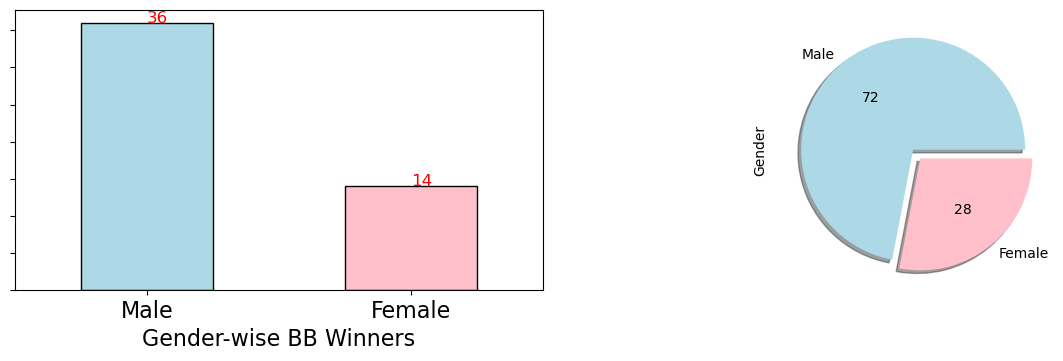

In [50]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(), '\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15, 8))
ax1=plt.subplot(221)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='bar', color=["lightblue","pink"], ec="k")
plt.xlabel("Gender-wise BB Winners", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts()):
    plt.annotate(y,(x,y),fontsize=12,color="Red")
    
ax2=plt.subplot(222)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='pie',autopct='%.0f',explode = (0, 0.10),colors=["lightblue","pink"],shadow=True)

## ➡️ No wild card entry housemate won the Bigg Boss competition.

In [51]:
# Entry type (wildcard or not) of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Wild Card'].value_counts()

No    50
Name: Wild Card, dtype: int64

In [52]:
bigg_boss.loc[bigg_boss.Winner==1, 'Season Length'].value_counts().sort_index()

# Length of the season - Number of Winners

28      1
42      2
70      2
84      2
86      1
90      1
95      1
97      3
98     13
100     1
105    13
106     2
112     2
113     1
117     1
121     1
135     1
140     1
142     1
Name: Season Length, dtype: int64

In [53]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Housemates'].value_counts().sort_index()

# Number of Housemates in house - Number of Winners

10     1
13     1
15     6
16     5
17     6
18    11
19     6
20     9
21     3
22     1
24     1
Name: Number of Housemates, dtype: int64

In [54]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

1     1
2     2
4     5
5     7
6     7
7     7
8     5
9     6
10    3
11    1
12    4
13    1
14    1
Name: Number of Evictions Faced, dtype: Int64

In [55]:
# 4 re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1, 'Number of re-entries'].value_counts()

0    46
1     4
Name: Number of re-entries, dtype: Int64

In [56]:
# Bigg Boss title winners number of times elected as captain
bigg_boss.loc[bigg_boss.Winner==1, 'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain - Number of winners

0    12
1    16
2    16
3     2
4     2
Name: Number of times elected as Captain, dtype: Int64

## 🔵 BB Hindi Seasons

In [57]:
lang='Hindi'

# All Bigg Boss Hindi Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,17
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8
3,Hindi,1,Bobby Darling,Activist,Transgender,2006-11-03,NaT,1,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,Hindi,OTT S2,Jiya Shankar,Soap Actress,Female,2023-06-17,NaT,<NA>,2.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
330,Hindi,OTT S2,Manisha Rani,Social Media Star,Female,2023-06-17,NaT,<NA>,5.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
331,Hindi,OTT S2,Palak Purswani,Soap Actress,Female,2023-06-17,NaT,<NA>,13.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,17
332,Hindi,OTT S2,Pooja Bhatt,Actress,Female,2023-06-17,NaT,<NA>,11.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>


In [58]:
# Bigg Boss Hindi Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,2006-11-03,NaT,<NA>,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,4,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,8
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,<NA>,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
42,Hindi,3,Vindu Dara Singh,Actor,Male,2009-10-04,NaT,<NA>,NaN,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,2010-10-03,NaT,<NA>,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,2,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
62,Hindi,5,Juhi Parmar,Soap Actress,Female,2011-10-02,NaT,<NA>,NaN,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,4,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,29
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,2012-10-07,NaT,<NA>,NaN,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
102,Hindi,7,Gauhar Khan,Actress,Female,2013-09-15,NaT,<NA>,NaN,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,2,1,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,15,47
140,Hindi,Halla Bol,Gautam Gulati,Soap Actor,Male,2015-01-04,NaT,<NA>,NaN,No,28,10,2015-01-04,2015-01-31,Farah Khan,NaN,5000000.0,Colors,NaN,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,4,50
154,Hindi,9,Prince Narula,Reality Show Alumni,Male,2015-10-11,NaT,<NA>,NaN,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,4,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,15,40
175,Hindi,10,Manveer Gurjar,Commoner,Male,2016-10-16,NaT,<NA>,NaN,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,5000000.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,3,0,0.0,0.0,NaN,NaN,NaN,NaN,8,1,1.0,15,47


In [59]:
# Hindi Bigg Boss all seasons finalists
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,42
8,Hindi,1,Rahul Roy,Actor,Male,2006-11-03,NaT,<NA>,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,4,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,12,8
9,Hindi,1,Rakhi Sawant,Actress,Female,2006-11-03,NaT,11,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,25
10,Hindi,1,Ravi Kishan,Actor,Male,2006-11-03,2007-01-26,12,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,2,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,17
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,<NA>,NaN,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,1.0,14,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Hindi,16,Archana Gautam,Actress,Female,2022-10-01,NaT,19,NaN,No,135,17,2022-10-01,2023-02-12,Salman Khan,Karan Johar,0.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,5,1,1,0.0,1.0,NaN,NaN,NaN,NaN,8,1,0.0,19,26
310,Hindi,16,MC Stan,Singer,Male,2022-10-01,NaT,<NA>,NaN,No,135,17,2022-10-01,2023-02-12,Salman Khan,Karan Johar,3180000.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,8,1,0,0.0,0.0,NaN,NaN,NaN,NaN,9,1,1.0,19,42
312,Hindi,16,Priyanka Chahar Choudhary,Soap Actress,Female,2022-10-01,NaT,19,NaN,No,135,17,2022-10-01,2023-02-12,Salman Khan,Karan Johar,0.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,8,1,0.0,19,26
314,Hindi,16,Shalin Bhanot,Soap Actor,Male,2022-10-01,NaT,19,NaN,No,135,17,2022-10-01,2023-02-12,Salman Khan,Karan Johar,0.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,10,0,0,0.0,0.0,NaN,NaN,NaN,NaN,7,1,0.0,19,53


In [60]:
# Number of finalists gender wise, in each BB Hindi season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Gender')['Season Number'].value_counts().sort_index()

Gender  Season Number
Female  1                2
        10               2
        11               2
        12               1
        13               3
        14               3
        15               3
        16               2
        3                1
        4                2
        5                2
        6                2
        7                2
        8                3
        9                2
        Halla Bol        2
        OTT S1           2
Male    1                2
        10               2
        11               2
        12               4
        13               3
        14               2
        15               3
        16               3
        2                3
        3                2
        4                2
        5                3
        6                2
        7                2
        8                4
        9                2
        Halla Bol        3
        OTT S1           3
Name: Season Number, dtype: int64

## 🔺 Bigg Boss India data set visualizations/infographics at Tableau Public -
## http://public.tableau.com/app/profile/satya.thirumani/viz/BiggBossIndia_16434338263440/BBStory

In [61]:
IFrame('https://public.tableau.com/views/BiggBossIndia_16434338263440/BBStory?:language=en-US&:display_count=n&:origin=viz_share_link', width=1000, height=1000)

In [62]:
# Bigg Boss Hindi current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']=='OTT S2'), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
321,Hindi,OTT S2,Aaliya Siddiqui,Theatre Artist,Female,2023-06-17,NaT,<NA>,9.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
322,Hindi,OTT S2,Abhishek Malhan,Social Media Star,Male,2023-06-17,NaT,<NA>,3.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
323,Hindi,OTT S2,Akanksha Puri,Actress,Female,2023-06-17,NaT,<NA>,12.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,17
324,Hindi,OTT S2,Avinash Sachdev,Actor,Male,2023-06-17,NaT,<NA>,7.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
325,Hindi,OTT S2,Bebika Dhurve,Soap Actress,Female,2023-06-17,NaT,<NA>,8.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
326,Hindi,OTT S2,Cyrus Broacha,Comedian,Male,2023-06-17,NaT,<NA>,4.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
327,Hindi,OTT S2,Falaq Naaz,Soap Actress,Female,2023-06-17,NaT,<NA>,1.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
328,Hindi,OTT S2,Jad Hadid,Model,Male,2023-06-17,NaT,<NA>,6.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
329,Hindi,OTT S2,Jiya Shankar,Soap Actress,Female,2023-06-17,NaT,<NA>,2.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>
330,Hindi,OTT S2,Manisha Rani,Social Media Star,Female,2023-06-17,NaT,<NA>,5.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>


In [63]:
# Bigg Boss Hindi Housemate's Gender
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Gender'].value_counts(), "\n")

Female         174
Male           158
Transgender      2
Name: Gender, dtype: int64 



In [64]:
print("\nTop 2 Hindi contestants who faced maximum number of evictions\n")
tmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Number of Evictions Faced'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Number of Evictions Faced']>=tmax-1)][["Season Number","Name","Number of Evictions Faced"]].head(8).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))


Top 2 Hindi contestants who faced maximum number of evictions

Season Number          Name  Number of Evictions Faced
           14 Rubina Dilaik                         14
           13    Arti Singh                         13


In [65]:
print("\nTop 2 Hindi contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
tpmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Evictions Faced Percentage'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Evictions Faced Percentage']>=tpmax-16)][["Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(8).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))


Top 2 Hindi contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Season Number           Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
    Halla Bol  Dimpy Ganguly                          4                       4                         100
    Halla Bol Sambhavna Seth                          4                       4                         100


## 🔍 Preparing Data for ML modelling

In [66]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                0
Season Number                           0
Name                                    0
Profession                              0
Gender                                  0
Entry Date                            129
Elimination Date                      784
Elimination Week Number               147
Entry Numbr                           937
Wild Card                               0
Season Length                           0
Number of Housemates                    0
Season Start Date                       0
Season End Date                        13
Host Name                               0
Guest Host Name                       828
Prize Money (INR)                      21
Broadcasted By                         76
OTT Platform                          430
Average TRP                           421
Most Viewed States                      0
House Location                          0
OTT Season                              0
Number of Evictions Faced         

In [67]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [68]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].fillna(0)

In [69]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 41 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            971 non-null    object        
 1   Season Number                       971 non-null    object        
 2   Name                                971 non-null    object        
 3   Profession                          971 non-null    object        
 4   Gender                              971 non-null    object        
 5   Entry Date                          842 non-null    datetime64[ns]
 6   Elimination Date                    187 non-null    datetime64[ns]
 7   Elimination Week Number             824 non-null    Int32         
 8   Entry Numbr                         34 non-null     float64       
 9   Wild Card                           971 non-null    object        
 10  Season Length             

In [70]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,17,2006,2007,4,1
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Bobby Darling,Activist,Transgender,2006-11-03,NaT,1,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12,NaN,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,42,2006,2007,4,1


In [71]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
966,Malayalam,5,Sruthi Lakshmi,Soap Actress,Female,2023-03-26,NaT,8,17.0,No,105,21,2023-03-26,2023-07-14,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.057418,Kerala,Mumbai,No,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,20,2023,2023,1,3
967,Malayalam,5,Vishnu Joshi,Fitness Trainer,Male,2023-03-26,NaT,12,6.0,No,105,21,2023-03-26,2023-07-14,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.057418,Kerala,Mumbai,No,6,1,0,0.0,0.0,NaN,NaN,NaN,3.0,<NA>,0,0.0,15,40,2023,2023,1,3
968,Malayalam,5,Hanan Hameed,Social Media Star,Female,NaT,NaT,3,19.0,Yes,105,21,2023-03-26,2023-07-14,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.057418,Kerala,Mumbai,No,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,0,2023,2023,1,3
969,Malayalam,5,Omar Lulu,Film Director,Male,NaT,NaT,6,20.0,Yes,105,21,2023-03-26,2023-07-14,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.057418,Kerala,Mumbai,No,1,0,0,0.0,0.0,NaN,NaN,NaN,2.0,<NA>,0,0.0,15,7,2023,2023,1,3
970,Malayalam,5,Anu Joseph,Soap Actress,Female,NaT,NaT,10,21.0,Yes,105,21,2023-03-26,2023-07-14,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.057418,Kerala,Mumbai,No,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,13,2023,2023,1,3


In [72]:
# Updating last week-end elimination/entries manually
# bigg_boss.iloc[325,34] = 0

In [73]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
734,Tamil,Ultimate,Abhirami Venkatachalam,Model,Female,2022-01-30,NaT,10,NaN,No,70,16,2022-01-30,2022-04-10,Kamal Haasan,Simbu,0.0,NaN,Disney+ Hotstar,9.057418,Tamil Nadu,Chennai,Yes,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,10,50,2022,2022,1,2
760,Tamil,6,Nivaashiyni Saravanan,Model,Female,2022-10-09,NaT,6,NaN,No,105,21,2022-10-09,2023-01-22,Kamal Haasan,NaN,0.0,Star Vijay,Disney+ Hotstar,18.000000,Tamil Nadu,Chennai,No,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,20,2022,2023,4,1
429,Kannada,6,Muruli,News Presenter,Male,2018-10-21,NaT,11,NaN,No,100,20,2018-10-21,2019-01-27,Sudeep,NaN,0.0,Colors Super,Voot,9.057418,Karnataka,Bengaluru,No,4,1,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,14,29,2018,2019,4,1
920,Malayalam,3,Noby Marcose,Actor,Male,2021-02-14,NaT,<NA>,NaN,No,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,12.400000,Kerala,Chennai,No,3,2,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,21,2021,2021,1,2
435,Kannada,6,Shashi Kumar,Commoner,Male,2018-10-21,NaT,<NA>,NaN,No,100,20,2018-10-21,2019-01-27,Sudeep,NaN,5000000.0,Colors Super,Voot,9.057418,Karnataka,Bengaluru,No,9,1,0,0.0,0.0,NaN,NaN,NaN,NaN,8,1,1.0,14,64,2018,2019,4,1
215,Hindi,12,Saurabh Patel,Actor,Male,2018-09-16,NaT,5,NaN,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0.0,Colors,NaN,4.990000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,13,2018,2018,3,4
776,Marathi,1,Pushkar Jog,Actor,Male,2018-04-15,NaT,14,NaN,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,9.057418,Maharashtra,Lonavala,No,5,2,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,14,36,2018,2018,2,3
276,Hindi,OTT S1,Ridhima Pandit,Soap Actress,Female,2021-08-08,NaT,2,NaN,No,42,13,2021-08-08,2021-09-18,Karan Johar,NaN,0.0,NaN,Voot,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,6,17,2021,2021,3,3
253,Hindi,14,Rubina Dilaik,Soap Actress,Female,2020-10-03,NaT,<NA>,NaN,No,142,22,2020-10-03,2021-02-21,Salman Khan,NaN,3600000.0,Colors,Voot,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,14,1,0,0.0,0.0,NaN,NaN,NaN,NaN,9,1,1.0,20,70,2020,2021,4,1
722,Tamil,5,Nadia Chang,Model,Female,2021-10-03,NaT,2,NaN,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,Disney+ Hotstar,18.600000,Tamil Nadu,Chennai,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,15,7,2021,2022,4,1


In [74]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Hindi season

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
321,Hindi,OTT S2,Aaliya Siddiqui,Theatre Artist,Female,2023-06-17,NaT,<NA>,9.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>,2023,<NA>,2,<NA>
322,Hindi,OTT S2,Abhishek Malhan,Social Media Star,Male,2023-06-17,NaT,<NA>,3.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>,2023,<NA>,2,<NA>
323,Hindi,OTT S2,Akanksha Puri,Actress,Female,2023-06-17,NaT,<NA>,12.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,17,2023,<NA>,2,<NA>
324,Hindi,OTT S2,Avinash Sachdev,Actor,Male,2023-06-17,NaT,<NA>,7.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>,2023,<NA>,2,<NA>
325,Hindi,OTT S2,Bebika Dhurve,Soap Actress,Female,2023-06-17,NaT,<NA>,8.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>,2023,<NA>,2,<NA>
326,Hindi,OTT S2,Cyrus Broacha,Comedian,Male,2023-06-17,NaT,<NA>,4.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>,2023,<NA>,2,<NA>
327,Hindi,OTT S2,Falaq Naaz,Soap Actress,Female,2023-06-17,NaT,<NA>,1.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>,2023,<NA>,2,<NA>
328,Hindi,OTT S2,Jad Hadid,Model,Male,2023-06-17,NaT,<NA>,6.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>,2023,<NA>,2,<NA>
329,Hindi,OTT S2,Jiya Shankar,Soap Actress,Female,2023-06-17,NaT,<NA>,2.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>,2023,<NA>,2,<NA>
330,Hindi,OTT S2,Manisha Rani,Social Media Star,Female,2023-06-17,NaT,<NA>,5.0,No,42,13,2023-06-17,NaT,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,6,<NA>,2023,<NA>,2,<NA>


In [75]:
BB_Hindi_participants = test[['Name']]
BB_Hindi_participants.reset_index(drop=True, inplace=True)
BB_Hindi_participants

,Name
0,Aaliya Siddiqui
1,Abhishek Malhan
2,Akanksha Puri
3,Avinash Sachdev
4,Bebika Dhurve
5,Cyrus Broacha
6,Falaq Naaz
7,Jad Hadid
8,Jiya Shankar
9,Manisha Rani


In [76]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date"], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [77]:
train.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Soap Actor,Male,10,NaN,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,17,2006,2007,4,1
1,Hindi,1,Model,Female,5,NaN,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Pageant Winner,Male,4,NaN,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Activist,Transgender,1,NaN,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Model,Female,12,NaN,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,<NA>,1,0.0,12,42,2006,2007,4,1


In [78]:
test.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Entry Numbr,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Won ticket to Finale,Number of times Best Performer,Number of times Worst Performer,Social Media Popularity,Finalist,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
321,Hindi,OTT S2,Theatre Artist,Female,<NA>,9.0,No,42,13,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,6,<NA>,2023,<NA>,2,<NA>
322,Hindi,OTT S2,Social Media Star,Male,<NA>,3.0,No,42,13,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,6,<NA>,2023,<NA>,2,<NA>
323,Hindi,OTT S2,Actress,Female,<NA>,12.0,No,42,13,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,6,17,2023,<NA>,2,<NA>
324,Hindi,OTT S2,Actor,Male,<NA>,7.0,No,42,13,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,6,<NA>,2023,<NA>,2,<NA>
325,Hindi,OTT S2,Soap Actress,Female,<NA>,8.0,No,42,13,Salman Khan,NaN,NaN,NaN,JioCinema,9.057418,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,6,<NA>,2023,<NA>,2,<NA>


In [79]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

0.0    94.736842
1.0     5.263158
Name: Winner, dtype: float64


In [80]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [81]:
print(train2.shape)
print(test.shape)

(950, 389)
(12, 389)


In [82]:
train2.isnull().sum().sort_values(ascending=False)

Language_Hindi                 0
Number of Evictions Faced_2    0
Walked_2.0                     0
Walked_1.0                     0
Number of re-entries_3         0
                              ..
Season Length_86               0
Season Length_84               0
Season Length_75               0
Season Length_70               0
Season Ending Quarter_4        0
Length: 389, dtype: int64

In [83]:
train2.drop(["Profession_Doctor"], axis=1, inplace=True)
test.drop(["Profession_Doctor"], axis=1, inplace=True)

In [84]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Season Number_14,Season Number_15,Season Number_16,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_Halla Bol,Season Number_Non-Stop,Season Number_OTT,Season Number_OTT S1,...,Season Starting Year_2020,Season Starting Year_2021,Season Starting Year_2022,Season Starting Year_2023,Season Ending Year_2008,Season Ending Year_2009,Season Ending Year_2011,Season Ending Year_2012,Season Ending Year_2013,Season Ending Year_2014,Season Ending Year_2015,Season Ending Year_2016,Season Ending Year_2017,Season Ending Year_2018,Season Ending Year_2019,Season Ending Year_2020,Season Ending Year_2021,Season Ending Year_2022,Season Ending Year_2023,Season Starting Quarter_2,Season Starting Quarter_3,Season Starting Quarter_4,Season Ending Quarter_2,Season Ending Quarter_3,Season Ending Quarter_4
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [85]:
target.values

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [86]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.25, random_state=2023)
print(x_train.shape, x_val.shape)

(712, 388) (238, 388)


In [87]:
x_train.isnull().sum().sort_values(ascending=False)

Language_Hindi                 0
Number of Evictions Faced_2    0
Walked_2.0                     0
Walked_1.0                     0
Number of re-entries_3         0
                              ..
Season Length_86               0
Season Length_84               0
Season Length_75               0
Season Length_70               0
Season Ending Quarter_4        0
Length: 388, dtype: int64

## 💎 Machine Learning Modelling

In [88]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues')
    ax.set_xlabel('True Label', size=12)
    ax.set_ylabel('Predicted Label', size=12)

In [89]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2023, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=0.01: 88.19116267951382
F1 score for C=1: 90.95115819655857
F1 score for C=10: 96.34624119918237
F1 score for C=100: 96.34624119918237
F1 score for C=1000: 97.8162693648888


In [90]:
logi = LogisticRegression(random_state=2023, C=1000).fit(x_train, y_train)
logi

LogisticRegression(C=1000, random_state=2023)

In [91]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 97.8162693648888
Accuracy Score - 97.89915966386555


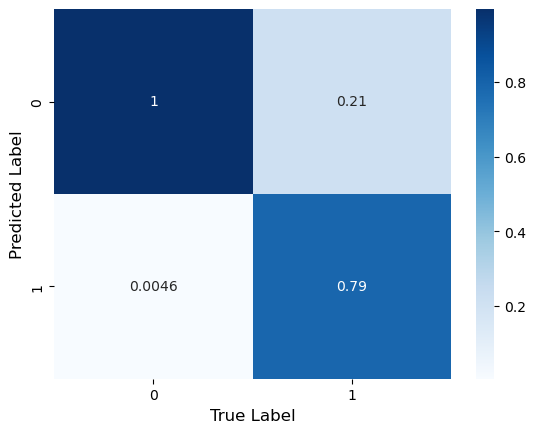

In [92]:
# Confusion Matrix
plot_confusion_matrix()

# TP 0.99 TN 1

In [93]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_Hindi_participants, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False).style.hide_index()

Name,Predicted_Winner
Bebika Dhurve,0.000235
Falaq Naaz,0.000235
Jiya Shankar,0.000235
Avinash Sachdev,0.000062
Cyrus Broacha,0.000027
Palak Purswani,0.000027
Pooja Bhatt,0.000019
Aaliya Siddiqui,0.000013
Jad Hadid,0.000005
Akanksha Puri,0.000002


## 💥 Predicted Winner for Bigg Boss Hindi OTT Season 2, as per Logistic Regression

In [94]:
# Predicted Winner for Bigg Boss Hindi OTT 2 Season, as per LogisticRegression
winner_lg[winner_lg['Predicted_Winner'] == np.amax(winner_lg.Predicted_Winner)].style.hide_index()

Name,Predicted_Winner
Bebika Dhurve,0.000235


In [95]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=2023).fit(x_train, y_train)
rf

RandomForestClassifier(n_estimators=200, random_state=2023)

In [96]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=200 accuracy 98.22

F1 Score - 96.63865546218487
Accuracy Score - 96.63865546218487


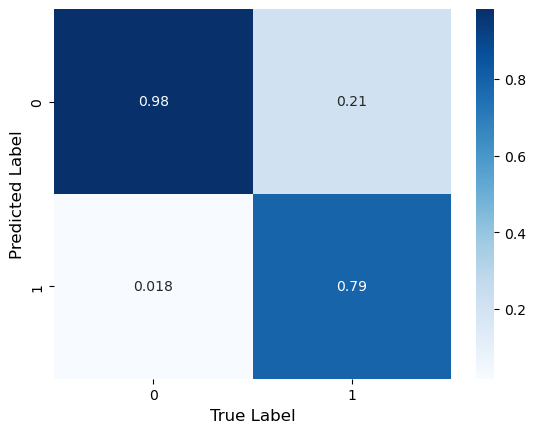

In [97]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 1

In [98]:
predicted_val_rf = rf.predict_proba(test)[:,1]
winner_rf = pd.concat([BB_Hindi_participants, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])],axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False).style.hide_index()

Name,Predicted_Winner
Aaliya Siddiqui,0.000000
Abhishek Malhan,0.000000
Akanksha Puri,0.000000
Avinash Sachdev,0.000000
Bebika Dhurve,0.000000
Cyrus Broacha,0.000000
Falaq Naaz,0.000000
Jad Hadid,0.000000
Jiya Shankar,0.000000
Manisha Rani,0.000000


## 💥 Predicted Winner for Bigg Boss Hindi OTT Season 2, as per Random Forest

In [99]:
# Predicted Winner for Bigg Boss Hindi OTT 2 Season, as per RandomForest
winner_rf[winner_rf['Predicted_Winner'] == np.amax(winner_rf.Predicted_Winner)].style.hide_index()

Name,Predicted_Winner
Aaliya Siddiqui,0.000000
Abhishek Malhan,0.000000
Akanksha Puri,0.000000
Avinash Sachdev,0.000000
Bebika Dhurve,0.000000
Cyrus Broacha,0.000000
Falaq Naaz,0.000000
Jad Hadid,0.000000
Jiya Shankar,0.000000
Manisha Rani,0.000000


## 🚀 Machine Learning (ML) models to predict Indian BiggBoss (Big Brother) season Winners

## Kannada Bigg Boss Season9
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-kannada-season-9-winner

## Telugu Bigg Boss Season7
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-telugu-season-7-winner

## Tamil Bigg Boss Season7
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-tamil-season-7-winner

## Malayalam Bigg Boss Season5
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-malayalam-season-5-winner

## Marathi Bigg Boss Season4
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-marathi-season-4-winner

## Bangla Bigg Boss Season3
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-bangla-season-3-winner

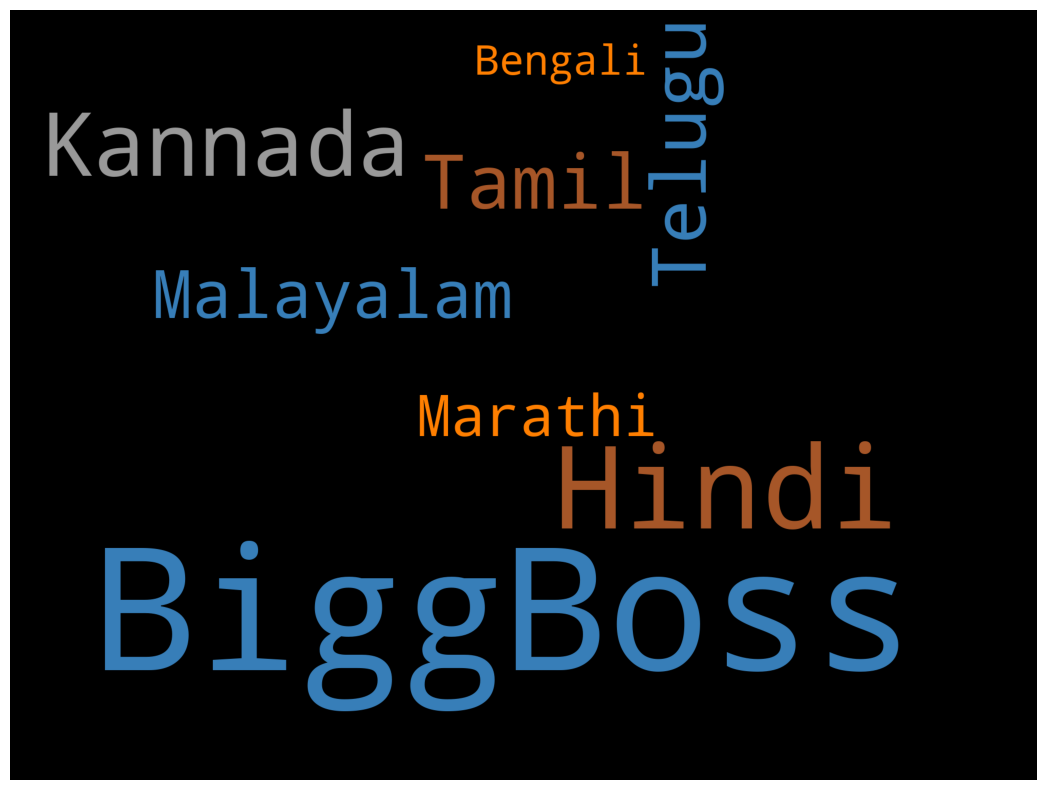

In [100]:
# Word cloud of Bigg Boss
text = " BiggBoss ".join(cat for cat in bigg_boss['Language'])
wordcloud = WordCloud(width=2000, height=1500, background_color='Black', colormap='Set1', collocations=False, random_state=2023).generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

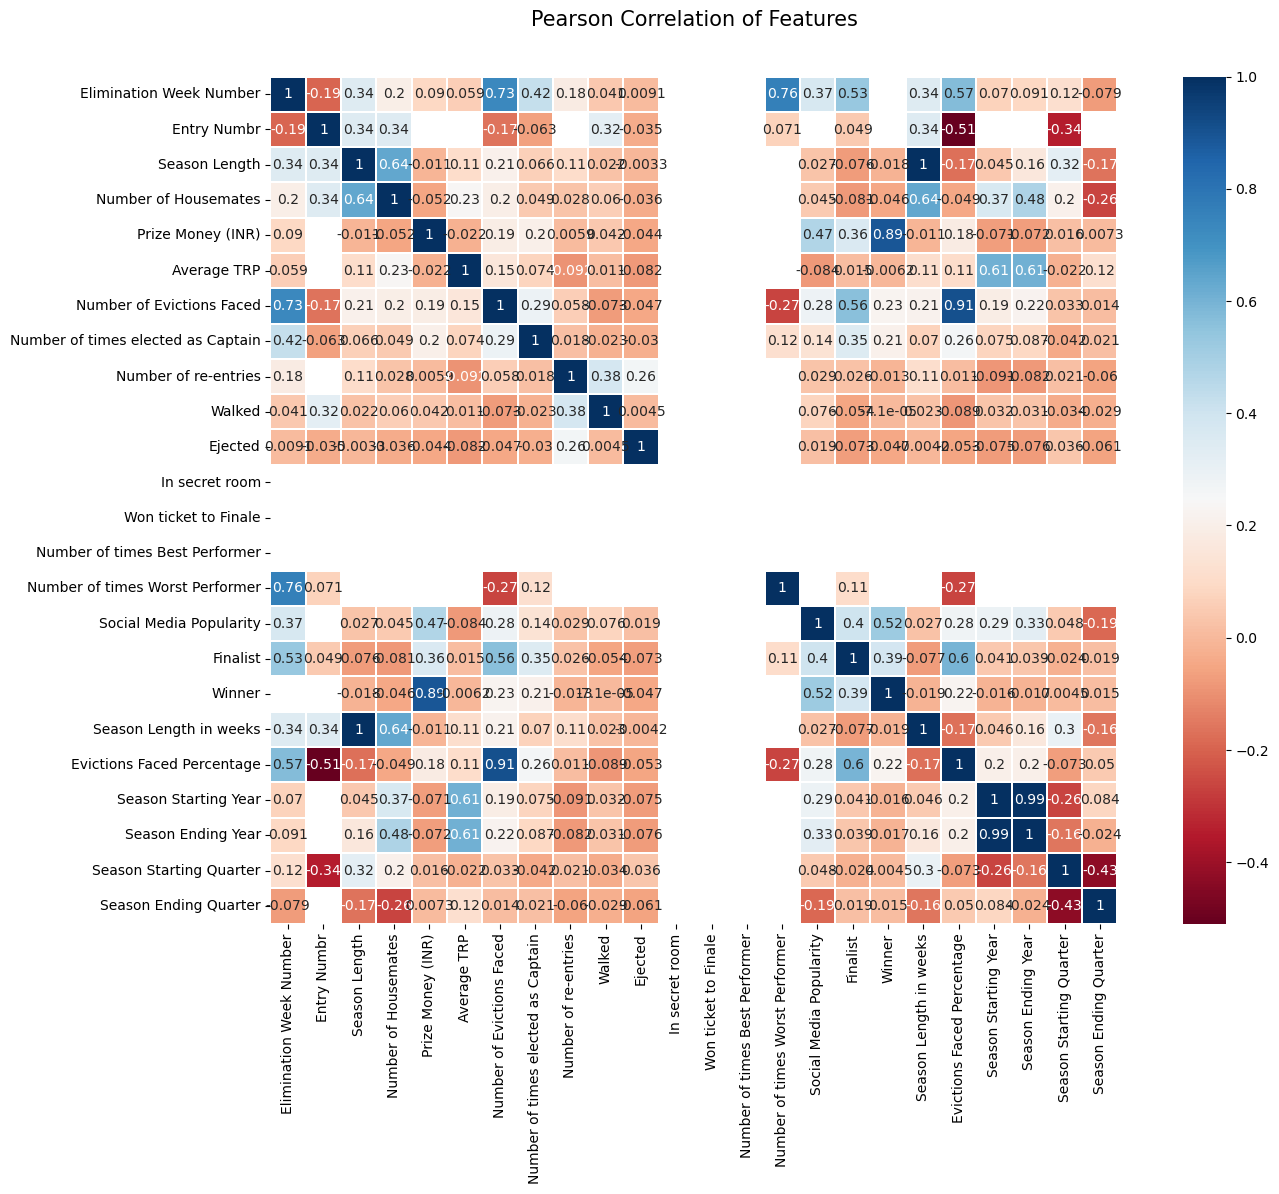

In [101]:
# Correlation matrix (Heatmap style)
corrmat = bigg_boss.corr()
f, ax = plt.subplots(figsize=(17, 11))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corrmat, vmax=1.0, linewidths=0.1, square=True, cmap="RdBu", linecolor='white', annot=True);

In [102]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
import matplotlib
print("matplotlib version: {}". format(matplotlib. __version__))
print("seaborn version: {}". format(sns.__version__))
import sklearn
print("sklearn version: {}". format(sklearn.__version__))
import plotly
print("plotly version: {}". format(plotly.__version__))

# Current versions
# numpy version: 1.23.5
# pandas version: 1.5.3
# matplotlib version: 3.7.1
# seaborn version: 0.12.2
# sklearn version: 1.2.2
# plotly version: 5.14.1

numpy version: 1.23.5
pandas version: 1.5.3
matplotlib version: 3.7.1
seaborn version: 0.12.2
sklearn version: 1.2.2
plotly version: 5.14.1
